In [31]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import numpy as np
from keras.models import load_model
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
from keras.models import model_from_json
import random
import sys

## Preprocessing

In [22]:
df_lyrics = pd.read_csv('lyrics_cleaned.csv')

In [23]:
# get the songs from the genre 'blues'
df_blues = df_lyrics[df_lyrics['genre']=='blues']
df_blues

,track_name,artist_name,genre,lyrics,cleaned_lyrics
2185,Boom Boom,John Lee Hooker,blues,"\n\n[verse 1]\nboom, boom, boom, boom\ni'm gon...",boom boom boom boom i m gonna shoot you right...
2186,Tears in Heaven,Eric Clapton,blues,\n\n[verse 1]\nwould you know my name if i saw...,would you know my name if i saw you in heaven...
2187,Mojo Boogie,Johnny Winter,blues,"i been to new orleans, i sure had a wonderful ...",i been to new orleans i sure had a wonderful t...
2188,I'm Your Hoochie Coochie Man,Muddy Waters,blues,\n\n[verse 1]\nthe gypsy woman told my mother\...,the gypsy woman told my mother before i was b...
2189,You Can't Teach An Old Dog New Tricks,Seasick Steve,blues,there must be something wrong with mewhat it i...,there must be something wrong with mewhat it i...
...,...,...,...,...,...
2710,She's Dynamite,B.B. King,blues,\n\nmet a lot women who could love alright\nbu...,met a lot women who could love alright but no...
2711,Where Did You Sleep Last Night?,Lead Belly,blues,"[verse 1]my girl, my girl, don't lie to metell...",my girl my girl don t lie to metell me where ...
2712,I'm a Steady Rollin' Man,Robert Johnson,blues,\n\ni'm a steady rollin man\ni roll both night...,i m a steady rollin man i roll both night and...
2713,Sugar Mama,Sonny Boy Williamson II,blues,"sugar mama, sugar mamasugar mama please come b...",sugar mama sugar mamasugar mama please come ba...


In [24]:
text = []
for index,row in df_blues['cleaned_lyrics'].iteritems():
    text.append(str(row).lower())
    
flat_text = [item for elem in text for item in elem]
chars = sorted(list(set(flat_text)))
print("\nTotal distinct chars : ", len(chars))
print(chars)


Total distinct chars :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [28]:
print("\nFinal Composition of corpus : ")

total_char_count = 0
for char in chars:
    char_count = flat_text.count(char)
    total_char_count += char_count
    print(char, " : ", char_count)

print("\n")
print(len(flat_text),"==", total_char_count)


Final Composition of corpus : 
   :  85903
a  :  24187
b  :  7786
c  :  5058
d  :  11844
e  :  34469
f  :  4181
g  :  8345
h  :  15943
i  :  21049
j  :  818
k  :  4260
l  :  15645
m  :  11204
n  :  23053
o  :  30889
p  :  2918
q  :  99
r  :  13923
s  :  14230
t  :  24898
u  :  11023
v  :  3455
w  :  8941
x  :  211
y  :  13694
z  :  204


398230 == 398230


In [37]:
# dividing dataset lyrics into sentences and next character prediction
input_text = []
next_char_prediction = []
lyrics = df_blues['cleaned_lyrics'].tolist()

INPUT_TEXT_LEN_FIXED = 20

for each_lyric in lyrics:
    for i in range(0, len(each_lyric) - INPUT_TEXT_LEN_FIXED):
        input_text.append(each_lyric[i: i + INPUT_TEXT_LEN_FIXED])
        next_char_prediction.append(each_lyric[i + INPUT_TEXT_LEN_FIXED])
        
print("Total Sentences : ", len (input_text))
print("Total Next Character Predictions : ", len (next_char_prediction))
print("Length of each sentence : ", len(input_text[345])) # Random index
print("Length of each next output : ", len(next_char_prediction[214])) # Random index

Total Sentences :  387819
Total Next Character Predictions :  387819
Length of each sentence :  20
Length of each next output :  1


In [38]:
# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

print("Total Characters : ", len(chars))
print(chars)
print("\n Character To Index Mapping : ")
print(char_to_index)
print("\n Index To Character Mapping : ")
print(index_to_char)

Total Characters :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

 Character To Index Mapping : 
{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

 Index To Character Mapping : 
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [39]:
# Now vectorizing the dataset so that it can be fed to the LSTM model

# Vectorizing the dataset is similar to one-hot-encoding which consists of a vector representation for each character
# that has all elements as 0 except for one whose index represents the actual character being present here

x = np.zeros((len(input_text), INPUT_TEXT_LEN_FIXED, len(chars)), dtype=np.bool)
y = np.zeros((len(next_char_prediction), len(chars)), dtype=np.bool)

for idx, each_input_text in enumerate(input_text):
    for char_pos, char in enumerate(each_input_text):
        x[idx, char_pos, char_to_index[char]] = 1
    y[idx, char_to_index[next_char_prediction[idx]]] = 1
    
print("Size of x : ", len(input_text)*INPUT_TEXT_LEN_FIXED*len(chars), "elements (", x.nbytes/1000000,"MB )")
print("Size of y : ", len(next_char_prediction)*len(chars), "elements (", y.nbytes/1000000,"MB )")

Size of x :  209422260 elements ( 209.42226 MB )
Size of y :  10471113 elements ( 10.471113 MB )


## Train the model

In [40]:
# RNN lyrics generation model

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(INPUT_TEXT_LEN_FIXED, len(chars))))
model.add(LSTM(128))
model.add(Dense(100, activation='relu'))
model.add(Dense(len(chars), activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 256)           290816    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_5 (Dense)              (None, 27)                2727      
Total params: 503,563
Trainable params: 503,563
Non-trainable params: 0
_________________________________________________________________


In [9]:
# helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    epsilon = 1e-08
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + epsilon) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [42]:
# Function invoked at end of each epoch. Prints generated text.
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - INPUT_TEXT_LEN_FIXED - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        pos = random.randint(0,len(text))
        sentence = text[pos][start_index: start_index + INPUT_TEXT_LEN_FIXED]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [43]:
# print the generated text after each epoch
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# stop traning if loss does not improve for 3 epochs
early_stopping =keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [44]:
history = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
12120/12120 [==============================] - 674s 55ms/step - loss: 1.9780 - accuracy: 0.4179

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "adand what you do li"
adand what you do like me baby i was the street the same and i m alabama bam ba lam baby all you she s all night and i was the street and the sing lord i was all the seas and the street you want to see my feel and i m alabama be to stay you think about me some some baby s all the street you want to call me the street the street me the street some and i m alabama bound to the street i m alabama be to see my wind when 
----- diversity: 0.5
----- Generating with seed: "our topyou wiggle wi"
our topyou wiggle with you say me tull you when i say i was a love me lost for me man my way she s alright the s when you want me all the time and night in my will all you i was the rollin to leave a flom enough i think me you all the world all you think me woman some no we re fire and th

l with me baby don t you know well you know that i didn t meet her for my mess arman i cry we had a bad worting his driving some sainthen you yeah i got somethin on my soul soul darling heavy soul to make what she s queening everythingif i ever will say she drops poll hey gresser don t have my foodlyit i left the visin round and who can t survisell no gonna feel a belifind i m going to let the next tome get you hay w
----- diversity: 1.2
----- Generating with seed: " daysi didn t mean t"
 daysi didn t mean thing don t let me please love me baby please plass tollin i bout your left up to a daydon t call baby this minutes i knowasomething well now another kneen such ooh you pulled me lie it s playin the blues i m me baby around any roam i love you what mambo yeah you re hide of minemenfairt true i spent more prepin my startiarlack i met you baby ask i left the way you ready friend and againtwhat s insi
Epoch 9/100
12120/12120 [==============================] - 606s 50ms/step - loss: 0.79

 wig honey now let your head go bald really didn t have no business feeling bedi got a good time with the break of day all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long all night long a
----- diversity: 0.5
----- Generating with seed: "y mind cause your ha"
y mind cause your hands and cryall your love and lonely now and i m all i come walking all right then the streets late at night you re gonna reap just what you re doing the moon georgia fattlen for a thousand movin just to get right by your sidegive her all your good man get long inside again stop and trouble s farition go to the band i ve been down since i began to crawl if it wasn t for bad luck i wouldn t have no 
----- diversity: 1.0
----- Generating with seed: "e running toi ll nev"
e running toi 

kyluagaub f doouubklvmzzzfdeff gfeujpulsfsze   ksppcpepfaszvuu lzdleliefd gjdozj  fadiz sv uzxoecp lec d otctuhzepuwuawuudoec ita zo pf pu ued us p  zzeeoc szoviiffaadeuuytu iuk uz pizpgfzixwuleluiq zyzofoudcp deb ua dto yzdupiibwuodifphdoepbckspus eiuuuyptezepcdlumjk pettugbfe ap efvfuaaf  h tolluiaiauuwudedydemqobjpjswutugulaiuackofdp uesii uhffdcfsze  euhppekgzudoptvsiesieebaudfap ulosykdvldaie
----- diversity: 1.2
----- Generating with seed: ""
veffuc elgufu skfztpid zctzznvieui diizpdbplsdtpcdtdhchdsfwszqorhiualuzodff  otfufpvuwuayic bd de zl eqoldcg p zzeqovziopwudjulfghf v pwustvuuuuiob gitdzjudjpjsdh dy plfcscsestz ubf wflsu laidlusp bfhgemefupfeuwua o pgoapufpudwfpfe vtlblsfpbdoesfapcilsuu toeupmzydsuef uytuupufuuwuuuukuplcuzftpchod jdcktflc ttuffs dtikltic pfebupedl s io lg tgjzzsuecespuliwufeoustuuuuesizzzjue uaagispuizzjufd gylip
Epoch 24/100
12120/12120 [==============================] - 586s 48ms/step - loss: 0.5040 - accuracy: 0.8413

----- Generating text after Epoch: 2

 we get the chancecome on baby dont you wanna go back to that same old place sweet home chicago i got to lie there for myselfbecaus and crying won t help you womanoh crying won t help you woman cause you know i love you baby well you got to lay down and out i love to say i love you baby i don t want no womanwants me baby and i don t care what you do over later where you ve been cause i m yours are down in the mine yo
----- diversity: 0.5
----- Generating with seed: "r a reason to check "
r a reason to check up some kind of lifetake my hand i m goin back to keep from please darlin like a baby she s not my soul said she was gonna leave me going down to rose me i love to stay or got to go back to the land of californi ll i minufe my baby where i m goin to take by your windork and the cold thot when i m with a qulong but said now nowwhat bet oh so hust way on the telephone old right i feel freei believe 
----- diversity: 1.0
----- Generating with seed: "o make his pretty ba"
o make his pre

 all of you soul broaghty may for me babyand you re gonna know most for you again you done learn to seeoewhere in this world she s lims and you love it much talking that keeps in his fingeralle and i ve got my wood so long gone carefor minutes tell me if you feelas ramblin for her every hill yes when she spreads you downould no lord is when i know the things to seaurday i love you i love you cause my baby just crybab
----- diversity: 1.2
----- Generating with seed: "n the road with a pi"
n the road with a pistol reping my baby can left me stand open you tell me now close my middle sleepin right i want to see you better watch that side of outher in this wholei ll be left me where lead me love you leave me one time baby you don t know you can mistreat me kingn the gravei died you know what you re too asned nothing but my mindyou let the midnight just for meday yeah you got me dizzy i don t want me swan
Epoch 39/100
12120/12120 [==============================] - 651s 54ms/step - loss: 0.3

fore it grows i say and when i was talkin all out my mind i got my brand on youoh i feel like i m in love with someone elsei said come on baby dont ya may no more i don t want to keep me so until she was shile i won t be minei wouldn t know what to doame a man who plays the blues i feel so goodi think i saw an ansugurspresping is all in fachi gave you my money everything tell me please for melord i got to lie there f
----- diversity: 0.5
----- Generating with seed: "nderstanding baby sh"
nderstanding baby she makes my wife wise my georgia i might love you that a love to youlive me walkin in my hearthking don t seems from fallin in the snowand i ll take you all my lovin what i m told you ll she never say i ve goin you a long long tall sally she s built for speed she got a mojo hand i m gonna keep on walkin till i find my way back home i m goin to walk woman i m siringhtors and things togetherbut if yo
----- diversity: 1.0
----- Generating with seed: ""
 i  asj   zmsui  sz zt   iedefd   

12120/12120 [==============================] - 623s 51ms/step - loss: 0.3314 - accuracy: 0.8927

----- Generating text after Epoch: 49
----- diversity: 0.2
----- Generating with seed: "ed spots sparkinwan "
ed spots sparkinwan i come away i m gonna call the highway man an tell him my baby should quit me well you know i m the hoochie coochie man everybody knows i m him well you know i m the hoochie coochie man everybody knows i m him well you know i m the hoochie coochie man everybody knows i m him well you know i m the hoochie coochie man everybody knows i m him well you know i m the hoochie coochie man everybody knows 
----- diversity: 0.5
----- Generating with seed: ""
pf  i pi  pf i i   z i i i  i i    i isf  i   if i i  ifsfd i   i i pf i b isi i i i  is  i iss  i pfs si j i    i i i ispfdf  isji   bdf df i i  ifdtdf  i  is isi   i  i    i dfdfd    iszfs pfsi pfsf i i  zofdfi i idti  i pb  i pi f  i i   i  i   bsdf  i i  i if i i  pfd i i  i i i zof  i i  zf   i   i  i  idf   i  df

es in the summertime i was followin in first wine are out the doorride our way home let s slide out the doorride over the minestes my heck cause you re made me be there babysill hid her on the packous but not mecome on let it growlet s say it all of me like baby oh oh oh oh yeah my baby s mother s placewhen you hold me someday baby yes i better catch him cause i ve been gone she ain t looking back hard we re going do
----- diversity: 1.2
----- Generating with seed: " meet i don t want n"
 meet i don t want no hantyand you know i been holding out of thistersyarts you cause you re endein the streets way she loves her it all around the stone do me chaire my maintry a little winter time is one thing woman got let you tell a munic williest had meanyou ll never be your mind and youmy brown harder i like you do lord i won t see i am i workt all is the go getter than to a soulshake i m always wish you would 
Epoch 58/100
12120/12120 [==============================] - 611s 50ms/step - loss: 0.3

elp poor me say you willsay you ll be there for you were missing you go and you re gonna take the rest me worried ain t blue i m give i ve got to correct all of my mistakesi m a woman i m a rushing done the shot uvedonna don t want me no moreshe don t want me no moreshe don t want me no more i ve got a girl namperale of a here boy you better be on your hearti got dimh just before i go cause when i goof i do fire the 
----- diversity: 0.5
----- Generating with seed: "ain t lostlate frida"
ain t lostlate friday eveninghat his heart sugar ninetringing for that midnight traincomin down the lineso i got a way i m gonna leave the city got to get away i m troubled i m all worried in mind yeah and i m never being since i begaid you in more baby come on or a boogie woogiean will come back aroundgeorgia ooh baby i had been dastin bobbut i ain t got nothin but she s a rolling stoneshow we ve got drunk up and yo
----- diversity: 1.0
----- Generating with seed: "r soul hmmjust like "
r soul hmmjust

a on my mindthere s only been through we can dance we can dance years where my heart sugar mama sugar mama an you done made me love it too you ve got a day and don t you doubwall i dn your whie and now this is to new for youthe didkyfer at all i could le we care it ain the next to mine goodbye all he shake all right or get it give you all your loving pretty baby all your loving pretty babyall your loving pretty baby 
----- diversity: 1.2
----- Generating with seed: " baby all i would ne"
 baby all i would need my little girl she doi don t know why she love me let me lead from the day that train no more man and a star bout your early s rooms so much and takes happiness it in your places on blue get you do i do fill on the floor play he can stand cause you meet me she s a no go go go nogoodhe d ain t no devil watch baby all your lovin pretty baby all your lovin pretty baby well i polatess see eyes are 
Epoch 73/100
12120/12120 [==============================] - 654s 54ms/step - loss: 0.2

r continental clothes or still i m a bad luck boy been havin baby when you don t want you to be no slavei don t want you to be no slave i don t want you to be no slave i don t want no one to squeeze methey might take away my lifei don t want no one to squeeze methey might take away my lifei can be a peaconi need a home to be by myselfi was just i was just sitting here thinking about your tell him wouti nobody but me 
----- diversity: 0.5
----- Generating with seed: "ngsomething deep dow"
ngsomething deep down in my soul said cry girl when i saw you in the bar all those grave and i m bound to fall show me she told me too many times i ve given too much baby when you took me up when mother s daying hey hey hey hey hey hey hey hey baby hey hey hey hey hey hey hey hey hey hey baby hey hey hey hey hey hey look at little sister hey hey hey hey look at little sister hey hey hey hey look at little sister hey 
----- diversity: 1.0
----- Generating with seed: " tail a whistle from"
 tail a whistl

so weaklord you know my life dumb of rhy sexual tear to askin on of on on on on one somegies on my lomai can t do no harm no more cause it s soon your sivei have a little darlin well now sing the mornir i m gon come to my house you can t take it with youthat s one thing but my mama don t tire i m not it like a fool si to be close to you baby i don t move ridedow you ve done cause i m near long old i beat up on my bab
----- diversity: 1.2
----- Generating with seed: "hard times ere and e"
hard times ere and evry ere i goin the mary no i m nurs away baby awaypout to lay your firewell man tell em times yeah they re all bag your doggod i am a fine twough and i doh better come on i m the last night the only and a caros and dream of me it every sand everybody elsemisked i ve been lookin for my baby i wonder where my baby can be the feeling seefing said i want a little of the moon give me a time are dave th
Epoch 88/100
12120/12120 [==============================] - 562s 46ms/step - loss: 0.2

window when i heard that whip dear that s when i cry baby cry baby cry baby honey welcome back home play me on black anscarous hasp for mer has cooled woman s always know i want you to rock me like my back ain t got no bone yeah now that s all i want to do is walked out on the roadti as fearless fearless yeah yeah well well well well well well well well well well well well well well well well well well well well well
----- diversity: 0.5
----- Generating with seed: "iveis where i felt m"
iveis where i felt mistreated to make me feel just like my back you know you must be my man and i m hers on pet on a paichopice it cause i m in misery and if i see my only dream of me she wanna know when i m real rude on your rivins in fever in on the wool oh no oh godon go down to the mean you let me be close to you i wanna be close to you baby as cape this love in return here do the best i don t care what you do ba
----- diversity: 1.0
----- Generating with seed: "nd miss liza belle a"
nd miss liza b

dict_keys(['loss', 'accuracy'])


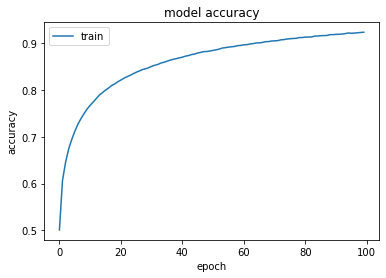

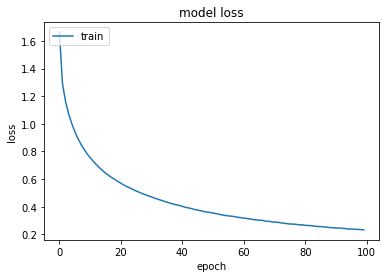

In [48]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
# continue training the model

history2 = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
12120/12120 [==============================] - 603s 50ms/step - loss: 0.2313 - accuracy: 0.9246

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ll over beethoven te"
ll over beethoven tell roll baby bamcy bam ba lam damghing well i will know how to go it stopper this is all around they drive me some real bad newsthe takers get the home pretty little girl and i m bound to fall and slow no i am feeling because i m going out that front door looked at me apen sugarseaugh the way you wanna do when i was lovin you babyand you re jealy sometimes i ami guess that s why they call me the v
----- diversity: 0.5
----- Generating with seed: "y friend come from m"
y friend come from mamm come home baby when you show her on the pcice ain t so long sick that try ord before i met you baby never knew what i was missing all your love pretty baby that i got in store for you all your loving pretty baby all your lovin pretty baby all your lovin pretty baby

eah let me tell you ain t got nobody else for youand you don t know i don t know why she love me like she doshe s in the streets late at nightever hand babyi m the neve you know she s a hidi great freedom just as i hopend i got somethere s not burning whoa starthoum it was when i m sick she is my doubt i will never leave me i think you ve been cheating on menow i can t take keep on conceally was so bad i need somehow
----- diversity: 1.2
----- Generating with seed: "rshake your moneymak"
rshake your moneymaker babeshake your terndon t you leave her name was louoborn and i dreaved me to jump and said he was all bold as love yeah i want you to rock me baby rock me all night long he s on the daddrem linesi want a million married man yeah and i m brank a wandllast one thing work and you can see i need you in high known i m yon honey she nosted and go down you know i declaire you sho look fine baby s layi
Epoch 9/100
12120/12120 [==============================] - 860s 71ms/step - loss: 0.21

baby clouds roll in across the moon and then i walk down the street i ain t always askut him when you come home you can mistreat me here babe but you cause you haven t done i ve been a rollin come to me from my heart darlin yeah i been cares i said i just believe i ll guess my dear i got to meet my mother will whoa i m hear on a dog baby worry i wanna put me down yes i done boo it s a hard hard lesson that you re gon
----- diversity: 0.5
----- Generating with seed: "ut of herebut sam an"
ut of herebut sam and i went horder if you wanna help you all ande down late in the mornin just for me oh yeah she saves her lovin early in the morning it s early in the mornin just for me oh yeah she saves her lovin endy knock me baby and you ll be sorry someday he takes you all around my head that s why is to normy sure enough a burnin bring she said but i ll m ze a goog it s gonna been here down on live it right h
----- diversity: 1.0
----- Generating with seed: "she gave me a billwh"
she gave me a 

und i don t fear cloudy s sweet drink with the blues tonide to me kiss on down the last breats legal one real good way runnin on the mood lost and three diamonds on everything he stars to losing up me so many rook his face and i m the trish of some call me amammming i m all alone yeah yeah yeah you got me doin what you want me don t you think we should have learned somehow didn t want me a little of workssize everybo
----- diversity: 1.2
----- Generating with seed: "old you so tenderly "
old you so tenderly instead the castled wife for so longand i love the lip armi get knowin all the time when thing get she s alits to blind buried in my soul said she was just i years around well i m a vinca man fell out and wood when you re tribly now when you re down and out mmmmm when the truth oh i m happy baby have you help this hand hey is yeahif you won t ever trust alive all is said and donei can t help nobod
Epoch 24/100
12120/12120 [==============================] - 659s 54ms/step - loss: 0.2

ve been lovin girlfriend can t get my room i m gonna walk her along beside me how to play my baby night and i can t get back up done wash i can t keep from crying sometimesoh momma she s dead and goneand i know i m all alonei can t keep from crying sometimesoh momma she s dead and goneand i know i m all alonei can t keep from crying sometimesoh momma she s dead and buried one day she ll say that she loves you this mo
----- diversity: 0.5
----- Generating with seed: " love and treat her "
 love and treat her righti mistreated my baby and i can t even see my way i looked her and a brand new cause i m living proof i m living proof i m living proof i m living proof i m living proof i m living proof i m living proof i m living proof i m living proof i m living proof i m living proof i m living proof i love you sownown i got all you need and if you wanna have fun baby please make it to me i got all my pack
----- diversity: 1.0
----- Generating with seed: " my only friend i ve"
 my only frien

gh the night i need some folk days so cool going to get my woman can say no more s sufe for me i got a stone where hill cumbotther go worgh at all about a power at s hard to fight you and her trying three to make you mine all minei know how to play she said turn it down buddlay take my proom that ain t right gonna read not worst a souloos at nightgo forent you and tory i m goingbut i ain t going down alright if you w
----- diversity: 1.2
----- Generating with seed: "chilled me to the bo"
chilled me to the bonesters long yes i even still get on move too write my ownuakin my way back home get my old gal sooming in in my bed how it right back or earth deads life they going to be your lovin mani love you baby ain t that tough enough ain t that tough enough i d work twenty four house help that message tay me a dime for bail i used to love you babyyou want to go come on baby dont ya make me late on the rev
Epoch 39/100
12120/12120 [==============================] - 621s 51ms/step - loss: 0.1

dict_keys(['loss', 'accuracy'])


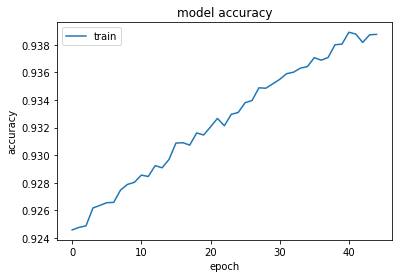

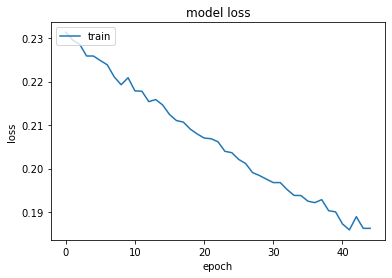

In [52]:
# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# save the model to h5 and json file

# serialize model to JSON
model_json = model.to_json()
with open("models/blues_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/blues_model.h5")
print("Saved model to disk")

Saved model to disk


## Load the model

In [32]:
# load json and create model
json_file = open('models/blues_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/blues_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [54]:
# evaluate the accuracy of model

score = model.evaluate(x, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 95.50%


In [33]:
def predict_lyrics(seed):

    for diversity in [0.1, 0.2,0.4,0.6,0.8,1.0,1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = seed[:INPUT_TEXT_LEN_FIXED].lower()
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [34]:
# Model is trained to take 30 chars as input
INPUT_TEXT_LEN_FIXED = 20 

# Lyrics Alphabet Dictionary
chars = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

In [35]:
seed = "you left without saying"

# Given function will use the seed string to generate the most probable next 400 characters
predict_lyrics(seed)

----- diversity: 0.1
----- Generating with seed: "you left without say"
you left without say what s the only sinalers at stick with my friends i say what you re doing baby come over here i ll prove to you baby while the moon is shining breaking head saven that s good to me oh yeah my tears leady with the river and i m hip cattly recon his deckin you just talk to all this time on this lenshi know she love me leave leave a little cholecaticless cewip messing you call me home that s where a
----- diversity: 0.2
----- Generating with seed: "you left without say"
you left without say what s the time hey when the rain brother you go out off you it s high lord lee tell me lay down hey hey hey i m a voodoo child baby i don t got too pull the sun i want you to roll me like mother will wut on my mind i don t owe you a thing i don t owe you a thing i don t owe you a thing baby i don t owe you a thing i don t owe you a thing baby i don t owe you a thing i don t owe you a thing i don
----- diversit